In [1]:
import numpy as np
import pyldpc as ldpc
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import sys
from utils_f import load_code
import os
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device='cuda:0'

In [3]:
H_filename = './source/BCH_15_11.alist'
code = load_code(H_filename)
H = code.H
G = code.G
var_degrees = code.var_degrees
chk_degrees = code.chk_degrees
num_edges = code.num_edges
u = code.u
d = code.d
n = code.n
m = code.m
k = code.k

In [4]:
class min_sum(torch.nn.Module):
    def __init__(self, num_iterations = 5):
        super(min_sum, self).__init__()
        self.W_cv = torch.ones((num_iterations, num_edges))
        # self.W_cv = torch.nn.Parameter(torch.abs(torch.ones((num_iterations, num_edges))))
        # self.W_cv.requires_grad = True
        self.B_cv = torch.zeros((num_iterations, num_edges))
        # self.B_cv = torch.nn.Parameter(torch.abs(torch.zeros((num_iterations, num_edges))))
        # self.B_cv.requires_grad = True
        self.W_vc = torch.ones((num_iterations, num_edges))
        # self.W_vc = torch.nn.Parameter(torch.abs(torch.ones((num_iterations, num_edges))))
        # self.W_vc.requires_grad = True
        
        self.num_iterations = num_iterations
        
    def forward(self, soft_input):
        soft_input = soft_input.T           # TODO! Fix matrix dimensions inside functions
        # print(soft_input.shape)
        cv = torch.zeros((num_edges, soft_input.shape[1]))
        for iteration in range(0, self.num_iterations):
            vc = self.compute_vc(cv, soft_input, iteration)
            cv = self.compute_cv(vc, iteration)
            soft_input = self.marginalize(soft_input, cv)
        output = torch.sigmoid(-soft_input)
        output = output.T
        
        # self.W_cv = torch.nn.Parameter(torch.abs(self.W_cv))
        # self.B_cv =torch.nn.Parameter(torch.abs(self.B_cv))
        # self.W_vc = torch.nn.Parameter(torch.abs(self.W_vc))
        # output = soft_input
        return output

        
    def compute_vc(self, cv, soft_input, iteration):
        edges = []
        for i in range(0, n):
            for j in range(0, var_degrees[i]):
                edges.append(i)
        # print(soft_input.shape, len(edges), edges)
        reordered_soft_input = torch.index_select(soft_input, 0, torch.tensor(edges).to(device))

        vc = torch.zeros((num_edges, cv.shape[1])).to(device)
        counter = 0
        edge_order = []

        for i in range(0, n): # for each variable node v
            for j in range(0, var_degrees[i]):
                edge_order.append(d[i][j])
                extrinsic_edges = []
                for jj in range(0, var_degrees[i]):
                    if jj != j: # extrinsic information only
                        extrinsic_edges.append(d[i][jj])
                # if the list of edges is not empty, add them up
                if extrinsic_edges:
                    # print(cv.shape, len(extrinsic_edges), extrinsic_edges)
                    temp = torch.index_select(cv.to(device), 0, torch.tensor(extrinsic_edges).to(device))
                    temp = torch.sum(temp, 0)
                else:
                    temp = torch.zeros(cv.shape[1])

                temp = temp.to(device)
                vc[counter] = temp
        
        new_order = np.zeros(num_edges).astype(int)
        new_order[edge_order] = np.arange(0, num_edges)
        vc = torch.index_select(vc, 0, torch.tensor(new_order).to(device))
        vc += reordered_soft_input * torch.tile(torch.reshape(self.W_vc[iteration], (-1,1)), (1, cv.shape[1])).to(device)       # add soft inputs of the previous iterations!
        return vc 

    def compute_cv(self, vc, iteration):
        cv_list = []
        prod_list = []
        min_list = []
        edge_order = []
        for i in range(0, m): # for each check node c
            for j in range(0, chk_degrees[i]):
                edge_order.append(u[i][j])
                extrinsic_edges = []
                for jj in range(0, chk_degrees[i]):
                    if jj != j:
                        extrinsic_edges.append(u[i][jj])
                temp = torch.index_select(vc.to(device),0,torch.tensor(extrinsic_edges).to(device))
                temp1 = torch.prod(torch.sign(temp),0)
                temp2 = torch.min(torch.abs(temp),0)[0]
                prod_list.append(temp1)
                min_list.append(temp2)
        prods = torch.stack(prod_list)
        mins = torch.stack(min_list)
        mins = torch.relu(mins - torch.tile(torch.reshape(self.B_cv[iteration], (-1,1)), (1, vc.shape[1])).to(device))
        cv = prods * mins
        new_order = np.zeros(num_edges).astype(int)
        new_order[edge_order] = np.array(range(0,num_edges)).astype(int)
        cv = torch.index_select(cv, 0, torch.tensor(new_order).to(device))
        cv = cv * torch.tile(torch.reshape(self.W_cv[iteration], (-1,1)), (1, vc.shape[1])).to(device)
        return cv

    # combine messages to get posterior LLRs
    def marginalize(self, soft_input, cv):
        weighted_soft_input = soft_input
        soft_output = []
        for i in range(0,n):
            edges = []
            for e in range(0,var_degrees[i]):
                edges.append(d[i][e])
            temp = torch.index_select(cv,0,torch.tensor(edges).to(device))
            temp = torch.sum(temp, 0)
            soft_output.append(temp)
        soft_output = torch.stack(soft_output)
        soft_output = weighted_soft_input + soft_output
        return soft_output

In [5]:
class Decoder(torch.nn.Module):
    def __init__(self, num_iterations = 5):
        super(Decoder, self).__init__()
        # self.W_cv = torch.ones((num_iterations, num_edges))
        self.W_cv = torch.nn.Parameter(torch.abs(torch.randn((num_iterations, num_edges))))
        self.W_cv.requires_grad = True
        # self.B_cv = torch.zeros((num_iterations, num_edges))
        self.B_cv = torch.nn.Parameter(torch.abs(torch.randn((num_iterations, num_edges))))
        self.B_cv.requires_grad = True
        # self.W_vc = torch.ones((num_iterations, num_edges))
        self.W_vc = torch.nn.Parameter(torch.abs(torch.randn((num_iterations, num_edges))))
        self.W_vc.requires_grad = True
        
        self.num_iterations = num_iterations
        
    def forward(self, soft_input):
        soft_input = soft_input.T           # TODO! Fix matrix dimensions inside functions
        # print(soft_input.shape)
        cv = torch.zeros((num_edges, soft_input.shape[1]))
        for iteration in range(0, self.num_iterations):
            vc = self.compute_vc(cv, soft_input, iteration)
            cv = self.compute_cv(vc, iteration)
            soft_input = self.marginalize(soft_input, cv)
        output = torch.sigmoid(-soft_input)
        output = output.T
        
        # self.W_cv = torch.nn.Parameter(torch.abs(self.W_cv))
        # self.B_cv =torch.nn.Parameter(torch.abs(self.B_cv))
        # self.W_vc = torch.nn.Parameter(torch.abs(self.W_vc))
        
        # output = soft_input
        return output

        
    def compute_vc(self, cv, soft_input, iteration):
        edges = []
        for i in range(0, n):
            for j in range(0, var_degrees[i]):
                edges.append(i)
        # print(soft_input.shape, len(edges), edges)
        reordered_soft_input = torch.index_select(soft_input, 0, torch.tensor(edges).to(device))

        vc = torch.zeros((num_edges, cv.shape[1])).to(device)
        counter = 0
        edge_order = []

        for i in range(0, n): # for each variable node v
            for j in range(0, var_degrees[i]):
                edge_order.append(d[i][j])
                extrinsic_edges = []
                for jj in range(0, var_degrees[i]):
                    if jj != j: # extrinsic information only
                        extrinsic_edges.append(d[i][jj])
                # if the list of edges is not empty, add them up
                if extrinsic_edges:
                    # print(cv.shape, len(extrinsic_edges), extrinsic_edges)
                    temp = torch.index_select(cv.to(device), 0, torch.tensor(extrinsic_edges).to(device))
                    temp = torch.sum(temp, 0)
                else:
                    temp = torch.zeros(cv.shape[1])

                temp = temp.to(device)
                vc[counter] = temp
        
        new_order = np.zeros(num_edges).astype(int)
        new_order[edge_order] = np.arange(0, num_edges)
        vc = torch.index_select(vc, 0, torch.tensor(new_order).to(device))
        vc += reordered_soft_input * torch.tile(torch.reshape(self.W_vc[iteration], (-1,1)), (1, cv.shape[1]))       # add soft inputs of the previous iterations!
        return vc 

    def compute_cv(self, vc, iteration):
        cv_list = []
        prod_list = []
        min_list = []
        edge_order = []
        for i in range(0, m): # for each check node c
            for j in range(0, chk_degrees[i]):
                edge_order.append(u[i][j])
                extrinsic_edges = []
                for jj in range(0, chk_degrees[i]):
                    if jj != j:
                        extrinsic_edges.append(u[i][jj])
                temp = torch.index_select(vc.to(device),0,torch.tensor(extrinsic_edges).to(device))
                temp1 = torch.prod(torch.sign(temp),0)
                temp2 = torch.min(torch.abs(temp),0)[0]
                prod_list.append(temp1)
                min_list.append(temp2)
        prods = torch.stack(prod_list)
        mins = torch.stack(min_list)
        mins = torch.relu(mins - torch.tile(torch.reshape(self.B_cv[iteration], (-1,1)), (1, vc.shape[1])))
        cv = prods * mins
        new_order = np.zeros(num_edges).astype(int)
        new_order[edge_order] = np.array(range(0,num_edges)).astype(int)
        cv = torch.index_select(cv, 0, torch.tensor(new_order).to(device))
        cv = cv * torch.tile(torch.reshape(self.W_cv[iteration], (-1,1)), (1, vc.shape[1]))
        return cv

    # combine messages to get posterior LLRs
    def marginalize(self, soft_input, cv):
        weighted_soft_input = soft_input
        soft_output = []
        for i in range(0,n):
            edges = []
            for e in range(0,var_degrees[i]):
                edges.append(d[i][e])
            temp = torch.index_select(cv,0,torch.tensor(edges).to(device))
            temp = torch.sum(temp, 0)
            soft_output.append(temp)
        soft_output = torch.stack(soft_output)
        soft_output = weighted_soft_input + soft_output
        return soft_output

In [6]:
def epoch_train(loader, clf, criterion, opt):
    clf.train(True)
    avg_loss = 0
    avg_acc = 0
    correct = 0
    # load batch
    for model_input, target in loader:
        # move data to device
        model_input = model_input.to(device)
        target = target.to(device)
        # calculate outputs, loss and accuracy
        model_output = clf(model_input)
        loss = criterion(model_output, target)
        # print(model_input[0], model_output[0])
        avg_loss += loss
        correct += torch.count_nonzero(torch.heaviside(model_output-0.5, torch.tensor([0.]).to(device)).to(device) == target)
        # calculate grad, upd weights
        opt.zero_grad()
        loss.backward()
        opt.step()
    avg_loss = avg_loss / len(loader)
    avg_acc = correct / len(loader.dataset)
    return avg_loss, avg_acc

            
            
                        
def epoch_test(loader, clf, criterion):
    clf.eval()
    avg_loss = 0
    avg_acc = 0
    correct = 0
    # load batch
    for model_input, target in loader:
        # move data to device
        model_input = model_input.to(device)
        target = target.to(device)
        # calculate outputs, loss and accuracy
        model_output = clf(model_input)
        loss = criterion(model_output, target)
        avg_loss += loss
        correct += torch.count_nonzero(torch.heaviside(model_output-0.5, torch.tensor([0.]).to(device)).to(device) == target)
    avg_loss = avg_loss / len(loader)
    avg_acc = correct / len(loader.dataset)

    return avg_loss, avg_acc

def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50):
    for epoch in trange(n_epochs):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion)
        # clf.apply(constraints)

        # clf.W_cv = torch.nn.Parameter(torch.relu(clf.W_cv))
        # clf.B_cv = torch.nn.Parameter(torch.relu(clf.B_cv))
        # clf.W_vc = torch.nn.Parameter(torch.relu(clf.W_vc))
        # print(clf.W_cv[0])


        if (np.mod(epoch+1,1)==0):
            print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' + 
                  f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

## Create dataloader

In [7]:
def gen():
    # messages = np.random.randint(0,2,[train_size,k])
    # codewords = messages @ G % 2
    # BPSK_codewords = (0.5 - codewords.astype(np.float32)) * 2.0
    codewords = torch.ones((train_size, n)).to(device)
    BPSK_codewords = -1*torch.ones_like(codewords).to(device)
    soft_input = torch.zeros_like(BPSK_codewords).to(device)
    SNRs = np.arange(1,6)
    for i in range(0,len(SNRs)):
        sigma = torch.sqrt(torch.tensor(1) / (2 * (k/n) * 10**(SNRs[i]/10))).to(device)
        noise = sigma * torch.randn((train_size//len(SNRs),n)).to(device)
        start_idx = train_size*i//len(SNRs)
        end_idx = train_size*(i+1)//len(SNRs)
        soft_input[start_idx:end_idx,:] = BPSK_codewords[start_idx:end_idx,:] + noise
        soft_input = 2 * soft_input / (sigma**2)
    return soft_input, codewords
    
def update_loaders():

    soft_input_train, codewords_train = gen()
    train_X = soft_input_train # transform to torch tensor
    train_y = codewords_train
    training_dataset = torch.utils.data.TensorDataset(train_X, train_y) # create your datset
    training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20000, shuffle=True) # create your dataloader


    soft_input_test, codewords_test = gen()
    test_X = soft_input_test # transform to torch tensor
    test_y = codewords_test
    test_dataset = torch.utils.data.TensorDataset(test_X, test_y) # create your datset
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20000, shuffle=True) # create your dataloader
    return training_loader, test_loader

In [8]:
decoder = Decoder(num_iterations=5).to(device)
# opt = torch.optim.Adam(decoder.parameters(), lr=0.0025)
opt = torch.optim.SGD(decoder.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.MSELoss()

In [9]:
test_size = 100000
req_err = 500*n
SNRs = np.arange(-10,5)

In [10]:
# hard decisions, classic min-sum
ms = min_sum(num_iterations=5).to(device)

bit_errors_hard = torch.zeros(len(SNRs)).to(device)
nb_bits_hard = torch.zeros(len(SNRs)).to(device)
bit_errors_min_sum = torch.zeros(len(SNRs)).to(device)
nb_bits_min_sum = torch.zeros(len(SNRs)).to(device)
for i, snr in enumerate(SNRs):
            while bit_errors_min_sum[i] < req_err:
                # messages = torch.randint(0, 2, (test_size, k))
                codewords = torch.ones((test_size, n)).to(device)
                BPSK_codewords = -1*torch.ones_like(codewords).to(device)
                # codewords = messages @ G % 2
                # codewords = codewords.to(device)
                # BPSK_codewords = (0.5 - codewords) * 2
                sigma = torch.sqrt(torch.tensor(1) / (2 * (k/n) * 10**(snr/10)))
                noise = sigma * torch.randn(test_size, n).to(device)
                soft_input = BPSK_codewords + noise
                bit_errors_hard[i] += torch.count_nonzero((-(torch.sign(soft_input) - 1)/2) != codewords)
                bit_errors_min_sum[i] += torch.count_nonzero(torch.heaviside(ms(soft_input) - 0.5, torch.tensor([0.]).to(device)) != codewords)
                nb_bits_hard[i] += test_size * n
                nb_bits_min_sum[i] += test_size * n
                print(f'SNR: {snr}, {100*bit_errors_min_sum[i]/req_err :.3f}%, test BER: {bit_errors_min_sum[i] / nb_bits_min_sum[i]}                ', end='\r')
            print('\n')

SNR: -10, 7287.427%, test BER: 0.36437132954597473                

SNR: -9, 6980.547%, test BER: 0.3490273356437683                

SNR: -8, 6650.640%, test BER: 0.33253198862075806                

SNR: -7, 6252.813%, test BER: 0.3126406669616699                

SNR: -6, 5830.640%, test BER: 0.2915320098400116                

SNR: -5, 5415.040%, test BER: 0.2707520127296448                

SNR: -4, 4891.747%, test BER: 0.24458733201026917                

SNR: -3, 4349.747%, test BER: 0.21748733520507812                

SNR: -2, 3724.093%, test BER: 0.1862046718597412                

SNR: -1, 3033.853%, test BER: 0.15169267356395721                

SNR: 0, 2315.853%, test BER: 0.1157926693558693                

SNR: 1, 1592.427%, test BER: 0.0796213299036026                

SNR: 2, 971.853%, test BER: 0.048592668026685715                

SNR: 3, 509.800%, test BER: 0.02549000084400177                

SNR: 4, 216.320%, test BER: 0.010816000401973724                



In [11]:
class weightConstraint(object):
    def __init__(self):
        pass
    
    def __call__(self,module):
        if hasattr(module,'weight'):
            print("Entered")
            W_cv=module.W_cv
            W_cv = torch.clamp(W_cv, min=0)
            module.W_cv=W_cv
            B_cv=module.B_cv
            B_cv = torch.clamp(W_cv, min=0)
            module.B_cv=B_cv
            W_vc=module.W_vc
            W_vc = torch.clamp(W_vc, min=0)
            module.W_vc=W_vc

In [12]:
constraints=weightConstraint()

In [13]:
train_size = 50000
n_upd = 500
bit_errors_nn = torch.zeros((n_upd, len(SNRs))).to(device)
nb_bits_nn = torch.zeros((n_upd, len(SNRs))).to(device)
ber_list = []

for upd in range(n_upd):
    print(f'TRAINING ITERATION #{upd+1}/{n_upd}')
    training_loader, test_loader = update_loaders()
    train(training_loader, test_loader, decoder, criterion, opt, n_epochs=3)

    if (np.mod(upd+1,5)==0):
        decoder.eval()
        for i, snr in enumerate(SNRs):
            while bit_errors_nn[upd][i] < req_err:
                # messages = torch.randint(0, 2, (test_size, k))
                # codewords = messages @ G % 2
                # codewords = codewords.to(device)
                # BPSK_codewords = (0.5 - codewords) * 2
                codewords = torch.ones((test_size, n)).to(device)
                BPSK_codewords = -1*torch.ones_like(codewords).to(device)
                sigma = torch.sqrt(torch.tensor(1) / (2 * (np.float(k)/np.float(n)) * 10**(snr/10)))
                noise = sigma * torch.randn(test_size, n).to(device)
                soft_input = BPSK_codewords + noise
                bit_errors_nn[upd][i] += torch.count_nonzero(torch.heaviside(decoder(soft_input) - 0.5, torch.tensor([0.]).to(device)) != codewords)
                nb_bits_nn[upd][i] += test_size * n
                print(f'SNR: {snr}, {100*bit_errors_nn[upd][i]/req_err :.3f}%, test BER: {bit_errors_nn[upd][i] / nb_bits_nn[upd][i]}                ', end='\r')
            print('\n')
        ber_list.append((bit_errors_nn[upd,-1].cpu() / nb_bits_nn[upd,-1].cpu()).numpy())    
        np.savetxt('ber.txt', ber_list)

[Epoch 2] train loss: 40.763; train acc: 14.56; test loss: 40.765; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.45s/it]

[Epoch 3] train loss: 40.763; train acc: 14.56; test loss: 40.765; test acc: 14.56
SNR: -10, 7027.000%, test BER: 0.35135000944137573                



SNR: -9, 6692.000%, test BER: 0.3346000015735626                

SNR: -8, 6313.053%, test BER: 0.31565266847610474                

SNR: -7, 5910.200%, test BER: 0.2955099940299988                

SNR: -6, 5453.414%, test BER: 0.2726706564426422                

SNR: -5, 4970.427%, test BER: 0.2485213279724121                

SNR: -4, 4441.400%, test BER: 0.22206999361515045                

SNR: -3, 3899.800%, test BER: 0.19498999416828156                

SNR: -2, 3341.480%, test BER: 0.16707399487495422                

SNR: -1, 2765.173%, test BER: 0.1382586658000946                

SNR: 0, 2214.027%, test BER: 0.11070133000612259                

SNR: 1, 1674.227%, test BER: 0.08371133357286453                

SNR: 2, 1186.787%, test BER: 0.059339333325624466                

SNR: 3, 783.413%, test BER: 0.03917066752910614                

SNR: 4, 471.400%, test BER: 0.023569999262690544                

TRAINING ITERATION #396/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.44s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.767; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.50s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.767; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.46s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.767; test acc: 14.55
TRAINING ITERATION #397/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.41s/it]

[Epoch 1] train loss: 40.765; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.47s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.763; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.46s/it]


[Epoch 3] train loss: 40.765; train acc: 14.56; test loss: 40.764; test acc: 14.56
TRAINING ITERATION #398/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:03,  1.51s/it]

[Epoch 1] train loss: 40.765; train acc: 14.56; test loss: 40.766; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:03<00:01,  1.52s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.766; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.52s/it]


[Epoch 3] train loss: 40.765; train acc: 14.56; test loss: 40.765; test acc: 14.55
TRAINING ITERATION #399/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.47s/it]

[Epoch 1] train loss: 40.765; train acc: 14.56; test loss: 40.766; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.49s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.766; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.49s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.766; test acc: 14.55
TRAINING ITERATION #400/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.38s/it]

[Epoch 1] train loss: 40.765; train acc: 14.55; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.42s/it]

[Epoch 2] train loss: 40.765; train acc: 14.55; test loss: 40.765; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]

[Epoch 3] train loss: 40.765; train acc: 14.55; test loss: 40.765; test acc: 14.56
SNR: -10, 7014.027%, test BER: 0.35070133209228516                



SNR: -9, 6688.360%, test BER: 0.33441799879074097                

SNR: -8, 6324.907%, test BER: 0.31624534726142883                

SNR: -7, 5915.533%, test BER: 0.2957766652107239                

SNR: -6, 5441.894%, test BER: 0.2720946669578552                

SNR: -5, 4969.880%, test BER: 0.2484939992427826                

SNR: -4, 4450.467%, test BER: 0.22252333164215088                

SNR: -3, 3913.120%, test BER: 0.19565600156784058                

SNR: -2, 3339.587%, test BER: 0.1669793277978897                

SNR: -1, 2763.667%, test BER: 0.1381833404302597                

SNR: 0, 2211.507%, test BER: 0.11057533323764801                

SNR: 1, 1664.987%, test BER: 0.08324933052062988                

SNR: 2, 1188.787%, test BER: 0.05943933501839638                

SNR: 3, 774.573%, test BER: 0.03872866556048393                

SNR: 4, 467.947%, test BER: 0.023397333920001984                

TRAINING ITERATION #401/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.40s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.766; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.44s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.766; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.45s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.766; test acc: 14.55
TRAINING ITERATION #402/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.48s/it]

[Epoch 1] train loss: 40.766; train acc: 14.55; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.45s/it]

[Epoch 2] train loss: 40.766; train acc: 14.55; test loss: 40.765; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]


[Epoch 3] train loss: 40.766; train acc: 14.55; test loss: 40.765; test acc: 14.56
TRAINING ITERATION #403/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.42s/it]

[Epoch 1] train loss: 40.763; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.46s/it]

[Epoch 2] train loss: 40.763; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.47s/it]


[Epoch 3] train loss: 40.763; train acc: 14.56; test loss: 40.764; test acc: 14.56
TRAINING ITERATION #404/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.50s/it]

[Epoch 1] train loss: 40.765; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:03<00:01,  1.51s/it]

[Epoch 2] train loss: 40.765; train acc: 14.56; test loss: 40.765; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.51s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56
TRAINING ITERATION #405/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.43s/it]

[Epoch 1] train loss: 40.766; train acc: 14.55; test loss: 40.763; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.46s/it]

[Epoch 2] train loss: 40.766; train acc: 14.55; test loss: 40.763; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.45s/it]

[Epoch 3] train loss: 40.766; train acc: 14.55; test loss: 40.764; test acc: 14.56
SNR: -10, 7047.093%, test BER: 0.35235467553138733                



SNR: -9, 6705.693%, test BER: 0.33528468012809753                

SNR: -8, 6324.187%, test BER: 0.3162093460559845                

SNR: -7, 5893.747%, test BER: 0.29468733072280884                

SNR: -6, 5449.040%, test BER: 0.2724519968032837                

SNR: -5, 4962.187%, test BER: 0.2481093406677246                

SNR: -4, 4451.560%, test BER: 0.2225780040025711                

SNR: -3, 3905.240%, test BER: 0.19526199996471405                

SNR: -2, 3345.627%, test BER: 0.16728132963180542                

SNR: -1, 2773.933%, test BER: 0.13869667053222656                

SNR: 0, 2203.760%, test BER: 0.11018799990415573                

SNR: 1, 1680.587%, test BER: 0.08402933180332184                

SNR: 2, 1192.387%, test BER: 0.05961933359503746                

SNR: 3, 784.693%, test BER: 0.039234668016433716                

SNR: 4, 469.320%, test BER: 0.023466000333428383                

TRAINING ITERATION #406/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.38s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.765; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.44s/it]

[Epoch 2] train loss: 40.763; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.45s/it]


[Epoch 3] train loss: 40.765; train acc: 14.56; test loss: 40.765; test acc: 14.56
TRAINING ITERATION #407/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.39s/it]

[Epoch 1] train loss: 40.765; train acc: 14.56; test loss: 40.765; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.46s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]


[Epoch 3] train loss: 40.763; train acc: 14.56; test loss: 40.765; test acc: 14.56
TRAINING ITERATION #408/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.44s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.767; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.49s/it]

[Epoch 2] train loss: 40.765; train acc: 14.56; test loss: 40.768; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.47s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.768; test acc: 14.55
TRAINING ITERATION #409/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.42s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.45s/it]

[Epoch 2] train loss: 40.765; train acc: 14.56; test loss: 40.765; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.49s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56
TRAINING ITERATION #410/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:03,  1.54s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.765; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:03<00:01,  1.54s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.765; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.53s/it]

[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.765; test acc: 14.55
SNR: -10, 7038.227%, test BER: 0.351911336183548                



SNR: -9, 6689.854%, test BER: 0.33449265360832214                

SNR: -8, 6308.333%, test BER: 0.3154166638851166                

SNR: -7, 5897.640%, test BER: 0.29488199949264526                

SNR: -6, 5451.934%, test BER: 0.27259665727615356                

SNR: -5, 4974.347%, test BER: 0.24871733784675598                

SNR: -4, 4451.027%, test BER: 0.22255133092403412                

SNR: -3, 3902.480%, test BER: 0.19512400031089783                

SNR: -2, 3353.227%, test BER: 0.16766133904457092                

SNR: -1, 2769.253%, test BER: 0.13846266269683838                

SNR: 0, 2202.680%, test BER: 0.11013399809598923                

SNR: 1, 1665.453%, test BER: 0.08327266573905945                

SNR: 2, 1187.867%, test BER: 0.05939333513379097                

SNR: 3, 776.400%, test BER: 0.03881999850273132                

SNR: 4, 467.027%, test BER: 0.023351334035396576                

TRAINING ITERATION #411/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.44s/it]

[Epoch 1] train loss: 40.766; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.44s/it]

[Epoch 2] train loss: 40.765; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]


[Epoch 3] train loss: 40.765; train acc: 14.56; test loss: 40.764; test acc: 14.56
TRAINING ITERATION #412/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.44s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.765; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.44s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56
TRAINING ITERATION #413/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:03,  1.52s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.765; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.49s/it]

[Epoch 2] train loss: 40.765; train acc: 14.56; test loss: 40.765; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.48s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.765; test acc: 14.56
TRAINING ITERATION #414/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.43s/it]

[Epoch 1] train loss: 40.763; train acc: 14.56; test loss: 40.763; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.46s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.763; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]


[Epoch 3] train loss: 40.765; train acc: 14.56; test loss: 40.763; test acc: 14.56
TRAINING ITERATION #415/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.42s/it]

[Epoch 1] train loss: 40.765; train acc: 14.55; test loss: 40.765; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.46s/it]

[Epoch 2] train loss: 40.765; train acc: 14.55; test loss: 40.765; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.47s/it]

[Epoch 3] train loss: 40.766; train acc: 14.55; test loss: 40.765; test acc: 14.56
SNR: -10, 7028.720%, test BER: 0.35143598914146423                



SNR: -9, 6698.053%, test BER: 0.33490267395973206                

SNR: -8, 6313.187%, test BER: 0.3156593441963196                

SNR: -7, 5896.120%, test BER: 0.29480600357055664                

SNR: -6, 5448.827%, test BER: 0.2724413275718689                

SNR: -5, 4960.920%, test BER: 0.24804599583148956                

SNR: -4, 4447.133%, test BER: 0.2223566621541977                

SNR: -3, 3914.453%, test BER: 0.19572266936302185                

SNR: -2, 3341.760%, test BER: 0.16708800196647644                

SNR: -1, 2786.173%, test BER: 0.13930866122245789                

SNR: 0, 2212.107%, test BER: 0.11060533672571182                

SNR: 1, 1672.267%, test BER: 0.0836133360862732                

SNR: 2, 1179.813%, test BER: 0.05899066850543022                

SNR: 3, 777.787%, test BER: 0.038889333605766296                

SNR: 4, 470.440%, test BER: 0.02352200075984001                

TRAINING ITERATION #416/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.44s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.48s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.49s/it]


[Epoch 3] train loss: 40.763; train acc: 14.56; test loss: 40.765; test acc: 14.56
TRAINING ITERATION #417/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.45s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.766; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.48s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.766; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.46s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.766; test acc: 14.55
TRAINING ITERATION #418/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.38s/it]

[Epoch 1] train loss: 40.765; train acc: 14.56; test loss: 40.766; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.42s/it]

[Epoch 2] train loss: 40.765; train acc: 14.56; test loss: 40.766; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.42s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.765; test acc: 14.55
TRAINING ITERATION #419/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.39s/it]

[Epoch 1] train loss: 40.767; train acc: 14.55; test loss: 40.765; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.46s/it]

[Epoch 2] train loss: 40.765; train acc: 14.55; test loss: 40.765; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.46s/it]


[Epoch 3] train loss: 40.765; train acc: 14.55; test loss: 40.765; test acc: 14.56
TRAINING ITERATION #420/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.41s/it]

[Epoch 1] train loss: 40.764; train acc: 14.55; test loss: 40.767; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.46s/it]

[Epoch 2] train loss: 40.765; train acc: 14.55; test loss: 40.766; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]

[Epoch 3] train loss: 40.765; train acc: 14.55; test loss: 40.768; test acc: 14.55
SNR: -10, 7038.813%, test BER: 0.35194066166877747                



SNR: -9, 6695.854%, test BER: 0.3347926735877991                

SNR: -8, 6306.240%, test BER: 0.315311998128891                

SNR: -7, 5900.813%, test BER: 0.29504066705703735                

SNR: -6, 5446.747%, test BER: 0.2723373472690582                

SNR: -5, 4948.653%, test BER: 0.2474326640367508                

SNR: -4, 4448.080%, test BER: 0.22240400314331055                

SNR: -3, 3906.053%, test BER: 0.19530266523361206                

SNR: -2, 3348.147%, test BER: 0.1674073338508606                

SNR: -1, 2779.907%, test BER: 0.13899533450603485                

SNR: 0, 2208.960%, test BER: 0.11044800281524658                

SNR: 1, 1668.560%, test BER: 0.08342800289392471                

SNR: 2, 1184.440%, test BER: 0.05922200158238411                

SNR: 3, 782.173%, test BER: 0.03910866752266884                

SNR: 4, 466.253%, test BER: 0.02331266738474369                

TRAINING ITERATION #421/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:03,  1.52s/it]

[Epoch 1] train loss: 40.765; train acc: 14.55; test loss: 40.766; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:03<00:01,  1.57s/it]

[Epoch 2] train loss: 40.764; train acc: 14.55; test loss: 40.766; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.54s/it]


[Epoch 3] train loss: 40.766; train acc: 14.56; test loss: 40.765; test acc: 14.55
TRAINING ITERATION #422/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.49s/it]

[Epoch 1] train loss: 40.765; train acc: 14.56; test loss: 40.767; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.45s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.767; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.46s/it]


[Epoch 3] train loss: 40.765; train acc: 14.56; test loss: 40.766; test acc: 14.55
TRAINING ITERATION #423/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.44s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.45s/it]

[Epoch 2] train loss: 40.765; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56
TRAINING ITERATION #424/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.50s/it]

[Epoch 1] train loss: 40.766; train acc: 14.55; test loss: 40.767; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.49s/it]

[Epoch 2] train loss: 40.765; train acc: 14.55; test loss: 40.766; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.48s/it]


[Epoch 3] train loss: 40.765; train acc: 14.55; test loss: 40.767; test acc: 14.55
TRAINING ITERATION #425/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.43s/it]

[Epoch 1] train loss: 40.767; train acc: 14.55; test loss: 40.766; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.43s/it]

[Epoch 2] train loss: 40.766; train acc: 14.55; test loss: 40.765; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]

[Epoch 3] train loss: 40.765; train acc: 14.55; test loss: 40.766; test acc: 14.55
SNR: -10, 7030.947%, test BER: 0.35154733061790466                



SNR: -9, 6690.253%, test BER: 0.3345126807689667                

SNR: -8, 6308.987%, test BER: 0.3154493272304535                

SNR: -7, 5906.347%, test BER: 0.29531732201576233                

SNR: -6, 5457.040%, test BER: 0.27285200357437134                

SNR: -5, 4977.053%, test BER: 0.2488526701927185                

SNR: -4, 4451.640%, test BER: 0.22258199751377106                

SNR: -3, 3904.160%, test BER: 0.19520799815654755                

SNR: -2, 3345.973%, test BER: 0.16729865968227386                

SNR: -1, 2768.120%, test BER: 0.13840599358081818                

SNR: 0, 2208.373%, test BER: 0.11041866987943649                

SNR: 1, 1671.360%, test BER: 0.08356799930334091                

SNR: 2, 1183.947%, test BER: 0.059197332710027695                

SNR: 3, 782.280%, test BER: 0.03911399841308594                

SNR: 4, 470.053%, test BER: 0.023502666503190994                

TRAINING ITERATION #426/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.44s/it]

[Epoch 1] train loss: 40.765; train acc: 14.55; test loss: 40.763; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:03<00:01,  1.51s/it]

[Epoch 2] train loss: 40.765; train acc: 14.55; test loss: 40.763; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.51s/it]


[Epoch 3] train loss: 40.766; train acc: 14.56; test loss: 40.764; test acc: 14.56
TRAINING ITERATION #427/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.49s/it]

[Epoch 1] train loss: 40.766; train acc: 14.55; test loss: 40.763; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.48s/it]

[Epoch 2] train loss: 40.766; train acc: 14.55; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.46s/it]


[Epoch 3] train loss: 40.765; train acc: 14.55; test loss: 40.764; test acc: 14.56
TRAINING ITERATION #428/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.44s/it]

[Epoch 1] train loss: 40.762; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.48s/it]

[Epoch 2] train loss: 40.763; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.46s/it]


[Epoch 3] train loss: 40.763; train acc: 14.56; test loss: 40.764; test acc: 14.56
TRAINING ITERATION #429/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.42s/it]

[Epoch 1] train loss: 40.766; train acc: 14.55; test loss: 40.767; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.45s/it]

[Epoch 2] train loss: 40.765; train acc: 14.55; test loss: 40.766; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.45s/it]


[Epoch 3] train loss: 40.766; train acc: 14.55; test loss: 40.766; test acc: 14.55
TRAINING ITERATION #430/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.42s/it]

[Epoch 1] train loss: 40.765; train acc: 14.55; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.48s/it]

[Epoch 2] train loss: 40.765; train acc: 14.55; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.47s/it]

[Epoch 3] train loss: 40.766; train acc: 14.55; test loss: 40.763; test acc: 14.56
SNR: -10, 7040.240%, test BER: 0.3520120084285736                



SNR: -9, 6691.227%, test BER: 0.3345613479614258                

SNR: -8, 6323.907%, test BER: 0.3161953389644623                

SNR: -7, 5912.320%, test BER: 0.2956160008907318                

SNR: -6, 5456.533%, test BER: 0.2728266716003418                

SNR: -5, 4961.520%, test BER: 0.24807600677013397                

SNR: -4, 4453.547%, test BER: 0.2226773351430893                

SNR: -3, 3911.787%, test BER: 0.1955893337726593                

SNR: -2, 3348.987%, test BER: 0.16744934022426605                

SNR: -1, 2776.680%, test BER: 0.13883399963378906                

SNR: 0, 2197.280%, test BER: 0.1098639965057373                

SNR: 1, 1667.720%, test BER: 0.08338599652051926                

SNR: 2, 1186.227%, test BER: 0.059311334043741226                

SNR: 3, 780.027%, test BER: 0.039001334458589554                

SNR: 4, 464.587%, test BER: 0.023229332640767097                

TRAINING ITERATION #431/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.45s/it]

[Epoch 1] train loss: 40.768; train acc: 14.55; test loss: 40.767; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.40s/it]

[Epoch 2] train loss: 40.767; train acc: 14.55; test loss: 40.766; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.43s/it]


[Epoch 3] train loss: 40.767; train acc: 14.55; test loss: 40.767; test acc: 14.55
TRAINING ITERATION #432/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:03,  1.62s/it]

[Epoch 1] train loss: 40.765; train acc: 14.56; test loss: 40.763; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:03<00:01,  1.59s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.56s/it]


[Epoch 3] train loss: 40.765; train acc: 14.56; test loss: 40.764; test acc: 14.56
TRAINING ITERATION #433/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:03,  1.51s/it]

[Epoch 1] train loss: 40.765; train acc: 14.56; test loss: 40.766; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.46s/it]

[Epoch 2] train loss: 40.765; train acc: 14.56; test loss: 40.766; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.46s/it]


[Epoch 3] train loss: 40.766; train acc: 14.56; test loss: 40.767; test acc: 14.55
TRAINING ITERATION #434/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.40s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.766; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.45s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.766; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.765; test acc: 14.55
TRAINING ITERATION #435/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.43s/it]

[Epoch 1] train loss: 40.763; train acc: 14.56; test loss: 40.763; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.45s/it]

[Epoch 2] train loss: 40.762; train acc: 14.56; test loss: 40.763; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.46s/it]

[Epoch 3] train loss: 40.763; train acc: 14.56; test loss: 40.762; test acc: 14.56
SNR: -10, 7030.627%, test BER: 0.35153132677078247                



SNR: -9, 6685.667%, test BER: 0.33428332209587097                

SNR: -8, 6319.414%, test BER: 0.31597065925598145                

SNR: -7, 5905.720%, test BER: 0.29528599977493286                

SNR: -6, 5434.107%, test BER: 0.2717053294181824                

SNR: -5, 4947.987%, test BER: 0.24739933013916016                

SNR: -4, 4452.747%, test BER: 0.222637340426445                

SNR: -3, 3899.200%, test BER: 0.19495999813079834                

SNR: -2, 3346.920%, test BER: 0.16734600067138672                

SNR: -1, 2777.040%, test BER: 0.13885200023651123                

SNR: 0, 2207.053%, test BER: 0.11035266518592834                

SNR: 1, 1669.160%, test BER: 0.08345799893140793                

SNR: 2, 1184.440%, test BER: 0.05922200158238411                

SNR: 3, 781.400%, test BER: 0.039069999009370804                

SNR: 4, 470.227%, test BER: 0.023511333391070366                

TRAINING ITERATION #436/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.38s/it]

[Epoch 1] train loss: 40.766; train acc: 14.55; test loss: 40.766; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.44s/it]

[Epoch 2] train loss: 40.765; train acc: 14.56; test loss: 40.766; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.45s/it]


[Epoch 3] train loss: 40.765; train acc: 14.56; test loss: 40.766; test acc: 14.55
TRAINING ITERATION #437/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.46s/it]

[Epoch 1] train loss: 40.765; train acc: 14.56; test loss: 40.765; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.48s/it]

[Epoch 2] train loss: 40.765; train acc: 14.56; test loss: 40.765; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.48s/it]


[Epoch 3] train loss: 40.765; train acc: 14.56; test loss: 40.765; test acc: 14.55
TRAINING ITERATION #438/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.45s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.765; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.48s/it]

[Epoch 2] train loss: 40.763; train acc: 14.56; test loss: 40.765; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.46s/it]


[Epoch 3] train loss: 40.763; train acc: 14.56; test loss: 40.765; test acc: 14.56
TRAINING ITERATION #439/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.40s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.42s/it]

[Epoch 2] train loss: 40.763; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.43s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.763; test acc: 14.56
TRAINING ITERATION #440/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.38s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.767; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.46s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.765; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.46s/it]

[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.765; test acc: 14.55
SNR: -10, 7035.480%, test BER: 0.3517740070819855                



SNR: -9, 6684.400%, test BER: 0.3342199921607971                

SNR: -8, 6307.107%, test BER: 0.3153553307056427                

SNR: -7, 5889.080%, test BER: 0.29445400834083557                

SNR: -6, 5445.827%, test BER: 0.2722913324832916                

SNR: -5, 4966.107%, test BER: 0.2483053356409073                

SNR: -4, 4455.640%, test BER: 0.22278200089931488                

SNR: -3, 3908.280%, test BER: 0.1954140067100525                

SNR: -2, 3341.493%, test BER: 0.16707466542720795                

SNR: -1, 2768.880%, test BER: 0.13844400644302368                

SNR: 0, 2199.680%, test BER: 0.10998400300741196                

SNR: 1, 1663.360%, test BER: 0.08316799998283386                

SNR: 2, 1195.893%, test BER: 0.05979466810822487                

SNR: 3, 780.587%, test BER: 0.039029333740472794                

SNR: 4, 470.453%, test BER: 0.023522667586803436                

TRAINING ITERATION #441/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.41s/it]

[Epoch 1] train loss: 40.765; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.44s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56
TRAINING ITERATION #442/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.46s/it]

[Epoch 1] train loss: 40.766; train acc: 14.55; test loss: 40.765; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.41s/it]

[Epoch 2] train loss: 40.766; train acc: 14.55; test loss: 40.765; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.42s/it]


[Epoch 3] train loss: 40.765; train acc: 14.55; test loss: 40.764; test acc: 14.56
TRAINING ITERATION #443/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.39s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.49s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.763; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.48s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.763; test acc: 14.56
TRAINING ITERATION #444/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.46s/it]

[Epoch 1] train loss: 40.763; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.50s/it]

[Epoch 2] train loss: 40.763; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.48s/it]


[Epoch 3] train loss: 40.763; train acc: 14.56; test loss: 40.763; test acc: 14.56
TRAINING ITERATION #445/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.43s/it]

[Epoch 1] train loss: 40.762; train acc: 14.57; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.43s/it]

[Epoch 2] train loss: 40.761; train acc: 14.57; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.42s/it]

[Epoch 3] train loss: 40.761; train acc: 14.57; test loss: 40.764; test acc: 14.56
SNR: -10, 7033.333%, test BER: 0.351666659116745                



SNR: -9, 6688.040%, test BER: 0.3344019949436188                

SNR: -8, 6301.107%, test BER: 0.31505534052848816                

SNR: -7, 5904.693%, test BER: 0.29523468017578125                

SNR: -6, 5446.493%, test BER: 0.27232468128204346                

SNR: -5, 4966.840%, test BER: 0.24834200739860535                

SNR: -4, 4448.440%, test BER: 0.22242200374603271                

SNR: -3, 3905.587%, test BER: 0.1952793300151825                

SNR: -2, 3348.067%, test BER: 0.16740334033966064                

SNR: -1, 2766.827%, test BER: 0.13834133744239807                

SNR: 0, 2209.160%, test BER: 0.11045800149440765                

SNR: 1, 1668.893%, test BER: 0.08344466984272003                

SNR: 2, 1182.867%, test BER: 0.05914333462715149                

SNR: 3, 782.533%, test BER: 0.039126668125391006                

SNR: 4, 467.267%, test BER: 0.023363333195447922                

TRAINING ITERATION #446/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.43s/it]

[Epoch 1] train loss: 40.763; train acc: 14.56; test loss: 40.766; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.45s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.766; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.766; test acc: 14.55
TRAINING ITERATION #447/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.43s/it]

[Epoch 1] train loss: 40.763; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.45s/it]

[Epoch 2] train loss: 40.763; train acc: 14.56; test loss: 40.765; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.46s/it]


[Epoch 3] train loss: 40.763; train acc: 14.56; test loss: 40.765; test acc: 14.55
TRAINING ITERATION #448/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.42s/it]

[Epoch 1] train loss: 40.765; train acc: 14.56; test loss: 40.765; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.45s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.765; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]


[Epoch 3] train loss: 40.766; train acc: 14.56; test loss: 40.767; test acc: 14.55
TRAINING ITERATION #449/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:03,  1.54s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:03<00:01,  1.58s/it]

[Epoch 2] train loss: 40.763; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.55s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56
TRAINING ITERATION #450/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.41s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.45s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.763; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.45s/it]

[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.763; test acc: 14.56
SNR: -10, 7035.760%, test BER: 0.3517880141735077                



SNR: -9, 6695.827%, test BER: 0.3347913324832916                

SNR: -8, 6310.693%, test BER: 0.31553468108177185                

SNR: -7, 5915.827%, test BER: 0.2957913279533386                

SNR: -6, 5455.227%, test BER: 0.27276134490966797                

SNR: -5, 4970.320%, test BER: 0.2485159933567047                

SNR: -4, 4450.773%, test BER: 0.22253866493701935                

SNR: -3, 3897.333%, test BER: 0.19486667215824127                

SNR: -2, 3347.760%, test BER: 0.16738800704479218                

SNR: -1, 2777.187%, test BER: 0.1388593316078186                

SNR: 0, 2209.853%, test BER: 0.11049266904592514                

SNR: 1, 1665.533%, test BER: 0.08327666670084                

SNR: 2, 1185.347%, test BER: 0.05926733464002609                

SNR: 3, 783.013%, test BER: 0.0391506664454937                

SNR: 4, 467.627%, test BER: 0.02338133379817009                

TRAINING ITERATION #451/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.46s/it]

[Epoch 1] train loss: 40.762; train acc: 14.56; test loss: 40.762; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.43s/it]

[Epoch 2] train loss: 40.762; train acc: 14.56; test loss: 40.763; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.42s/it]


[Epoch 3] train loss: 40.763; train acc: 14.56; test loss: 40.762; test acc: 14.56
TRAINING ITERATION #452/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.48s/it]

[Epoch 1] train loss: 40.763; train acc: 14.56; test loss: 40.765; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.41s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.765; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.42s/it]


[Epoch 3] train loss: 40.763; train acc: 14.56; test loss: 40.764; test acc: 14.56
TRAINING ITERATION #453/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:03,  1.51s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:03<00:01,  1.51s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.51s/it]


[Epoch 3] train loss: 40.765; train acc: 14.56; test loss: 40.765; test acc: 14.56
TRAINING ITERATION #454/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.39s/it]

[Epoch 1] train loss: 40.763; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.44s/it]

[Epoch 2] train loss: 40.763; train acc: 14.56; test loss: 40.763; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.46s/it]


[Epoch 3] train loss: 40.763; train acc: 14.56; test loss: 40.764; test acc: 14.56
TRAINING ITERATION #455/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.48s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:03<00:01,  1.54s/it]

[Epoch 2] train loss: 40.763; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.51s/it]

[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56
SNR: -10, 7035.133%, test BER: 0.35175666213035583                



SNR: -9, 6686.467%, test BER: 0.33432334661483765                

SNR: -8, 6325.213%, test BER: 0.3162606656551361                

SNR: -7, 5899.414%, test BER: 0.29497066140174866                

SNR: -6, 5453.560%, test BER: 0.2726779878139496                

SNR: -5, 4971.667%, test BER: 0.2485833317041397                

SNR: -4, 4447.227%, test BER: 0.22236132621765137                

SNR: -3, 3900.933%, test BER: 0.19504666328430176                

SNR: -2, 3341.640%, test BER: 0.16708199679851532                

SNR: -1, 2783.147%, test BER: 0.13915733993053436                

SNR: 0, 2202.933%, test BER: 0.110146664083004                

SNR: 1, 1658.773%, test BER: 0.08293866366147995                

SNR: 2, 1176.973%, test BER: 0.05884866788983345                

SNR: 3, 776.173%, test BER: 0.0388086661696434                

SNR: 4, 463.280%, test BER: 0.02316400036215782                

TRAINING ITERATION #456/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.40s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.765; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.46s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.765; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.45s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56
TRAINING ITERATION #457/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.48s/it]

[Epoch 1] train loss: 40.765; train acc: 14.56; test loss: 40.765; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:03<00:01,  1.56s/it]

[Epoch 2] train loss: 40.765; train acc: 14.56; test loss: 40.765; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.53s/it]


[Epoch 3] train loss: 40.766; train acc: 14.56; test loss: 40.765; test acc: 14.55
TRAINING ITERATION #458/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.42s/it]

[Epoch 1] train loss: 40.763; train acc: 14.56; test loss: 40.763; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.46s/it]

[Epoch 2] train loss: 40.762; train acc: 14.56; test loss: 40.763; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]


[Epoch 3] train loss: 40.763; train acc: 14.56; test loss: 40.763; test acc: 14.56
TRAINING ITERATION #459/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.41s/it]

[Epoch 1] train loss: 40.765; train acc: 14.56; test loss: 40.762; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.46s/it]

[Epoch 2] train loss: 40.765; train acc: 14.56; test loss: 40.762; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.46s/it]


[Epoch 3] train loss: 40.765; train acc: 14.56; test loss: 40.762; test acc: 14.56
TRAINING ITERATION #460/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.42s/it]

[Epoch 1] train loss: 40.768; train acc: 14.55; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:03<00:01,  1.55s/it]

[Epoch 2] train loss: 40.768; train acc: 14.55; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.53s/it]

[Epoch 3] train loss: 40.767; train acc: 14.55; test loss: 40.763; test acc: 14.56
SNR: -10, 7030.733%, test BER: 0.35153666138648987                



SNR: -9, 6692.894%, test BER: 0.3346446752548218                

SNR: -8, 6309.293%, test BER: 0.31546467542648315                

SNR: -7, 5887.947%, test BER: 0.2943973243236542                

SNR: -6, 5460.467%, test BER: 0.2730233371257782                

SNR: -5, 4965.854%, test BER: 0.24829266965389252                

SNR: -4, 4465.480%, test BER: 0.22327400743961334                

SNR: -3, 3905.240%, test BER: 0.19526199996471405                

SNR: -2, 3341.693%, test BER: 0.16708466410636902                

SNR: -1, 2772.280%, test BER: 0.1386139988899231                

SNR: 0, 2210.040%, test BER: 0.11050199717283249                

SNR: 1, 1665.133%, test BER: 0.08325666934251785                

SNR: 2, 1179.187%, test BER: 0.05895933508872986                

SNR: 3, 777.227%, test BER: 0.03886133432388306                

SNR: 4, 464.627%, test BER: 0.02323133312165737                

TRAINING ITERATION #461/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.43s/it]

[Epoch 1] train loss: 40.765; train acc: 14.56; test loss: 40.762; test acc: 14.57


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.47s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.762; test acc: 14.57


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.48s/it]


[Epoch 3] train loss: 40.765; train acc: 14.56; test loss: 40.761; test acc: 14.57
TRAINING ITERATION #462/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:03,  1.51s/it]

[Epoch 1] train loss: 40.763; train acc: 14.56; test loss: 40.765; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.48s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.766; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.48s/it]


[Epoch 3] train loss: 40.763; train acc: 14.56; test loss: 40.765; test acc: 14.55
TRAINING ITERATION #463/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.44s/it]

[Epoch 1] train loss: 40.766; train acc: 14.55; test loss: 40.763; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.49s/it]

[Epoch 2] train loss: 40.766; train acc: 14.55; test loss: 40.763; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.51s/it]


[Epoch 3] train loss: 40.765; train acc: 14.55; test loss: 40.763; test acc: 14.56
TRAINING ITERATION #464/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.41s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.762; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.46s/it]

[Epoch 2] train loss: 40.765; train acc: 14.56; test loss: 40.761; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.45s/it]


[Epoch 3] train loss: 40.765; train acc: 14.56; test loss: 40.762; test acc: 14.56
TRAINING ITERATION #465/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:03,  1.52s/it]

[Epoch 1] train loss: 40.765; train acc: 14.56; test loss: 40.763; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:03<00:01,  1.52s/it]

[Epoch 2] train loss: 40.765; train acc: 14.56; test loss: 40.763; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.52s/it]

[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.762; test acc: 14.56
SNR: -10, 7031.000%, test BER: 0.35155001282691956                



SNR: -9, 6674.107%, test BER: 0.333705335855484                

SNR: -8, 6316.693%, test BER: 0.3158346712589264                

SNR: -7, 5900.347%, test BER: 0.2950173318386078                

SNR: -6, 5460.667%, test BER: 0.2730333209037781                

SNR: -5, 4969.227%, test BER: 0.24846133589744568                

SNR: -4, 4441.747%, test BER: 0.2220873385667801                

SNR: -3, 3905.600%, test BER: 0.19528000056743622                

SNR: -2, 3336.080%, test BER: 0.1668040007352829                

SNR: -1, 2767.173%, test BER: 0.13835866749286652                

SNR: 0, 2203.027%, test BER: 0.11015133559703827                

SNR: 1, 1681.493%, test BER: 0.08407466858625412                

SNR: 2, 1181.213%, test BER: 0.05906066671013832                

SNR: 3, 775.000%, test BER: 0.038750000298023224                

SNR: 4, 467.280%, test BER: 0.023364000022411346                

TRAINING ITERATION #466/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:03,  1.53s/it]

[Epoch 1] train loss: 40.761; train acc: 14.56; test loss: 40.765; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:03<00:01,  1.55s/it]

[Epoch 2] train loss: 40.762; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.51s/it]


[Epoch 3] train loss: 40.762; train acc: 14.56; test loss: 40.764; test acc: 14.56
TRAINING ITERATION #467/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.40s/it]

[Epoch 1] train loss: 40.762; train acc: 14.56; test loss: 40.763; test acc: 14.57


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.46s/it]

[Epoch 2] train loss: 40.762; train acc: 14.56; test loss: 40.763; test acc: 14.57


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]


[Epoch 3] train loss: 40.762; train acc: 14.57; test loss: 40.762; test acc: 14.57
TRAINING ITERATION #468/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.42s/it]

[Epoch 1] train loss: 40.765; train acc: 14.56; test loss: 40.763; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.44s/it]

[Epoch 2] train loss: 40.765; train acc: 14.56; test loss: 40.763; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]


[Epoch 3] train loss: 40.765; train acc: 14.56; test loss: 40.763; test acc: 14.56
TRAINING ITERATION #469/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.42s/it]

[Epoch 1] train loss: 40.763; train acc: 14.56; test loss: 40.766; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.46s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.766; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]


[Epoch 3] train loss: 40.763; train acc: 14.56; test loss: 40.765; test acc: 14.55
TRAINING ITERATION #470/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.40s/it]

[Epoch 1] train loss: 40.762; train acc: 14.57; test loss: 40.763; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.46s/it]

[Epoch 2] train loss: 40.762; train acc: 14.57; test loss: 40.762; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.45s/it]

[Epoch 3] train loss: 40.762; train acc: 14.57; test loss: 40.762; test acc: 14.56
SNR: -10, 7032.507%, test BER: 0.35162532329559326                



SNR: -9, 6697.400%, test BER: 0.33487001061439514                

SNR: -8, 6325.934%, test BER: 0.31629666686058044                

SNR: -7, 5893.133%, test BER: 0.2946566641330719                

SNR: -6, 5448.107%, test BER: 0.27240532636642456                

SNR: -5, 4965.387%, test BER: 0.24826933443546295                

SNR: -4, 4451.533%, test BER: 0.22257666289806366                

SNR: -3, 3911.920%, test BER: 0.19559599459171295                

SNR: -2, 3348.373%, test BER: 0.1674186736345291                

SNR: -1, 2771.200%, test BER: 0.1385599970817566                

SNR: 0, 2204.320%, test BER: 0.11021599918603897                

SNR: 1, 1662.547%, test BER: 0.08312733471393585                

SNR: 2, 1185.467%, test BER: 0.059273332357406616                

SNR: 3, 776.360%, test BER: 0.03881800174713135                

SNR: 4, 466.307%, test BER: 0.02331533282995224                

TRAINING ITERATION #471/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:03,  1.51s/it]

[Epoch 1] train loss: 40.765; train acc: 14.55; test loss: 40.765; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:03<00:01,  1.53s/it]

[Epoch 2] train loss: 40.766; train acc: 14.55; test loss: 40.766; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.52s/it]


[Epoch 3] train loss: 40.766; train acc: 14.55; test loss: 40.766; test acc: 14.55
TRAINING ITERATION #472/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:03,  1.53s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.765; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.49s/it]

[Epoch 2] train loss: 40.763; train acc: 14.56; test loss: 40.765; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.48s/it]


[Epoch 3] train loss: 40.762; train acc: 14.56; test loss: 40.765; test acc: 14.55
TRAINING ITERATION #473/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:03,  1.50s/it]

[Epoch 1] train loss: 40.765; train acc: 14.56; test loss: 40.763; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.45s/it]

[Epoch 2] train loss: 40.765; train acc: 14.56; test loss: 40.762; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.45s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.763; test acc: 14.56
TRAINING ITERATION #474/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.40s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.48s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.45s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56
TRAINING ITERATION #475/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.40s/it]

[Epoch 1] train loss: 40.763; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.44s/it]

[Epoch 2] train loss: 40.763; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]

[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.763; test acc: 14.56
SNR: -10, 7027.707%, test BER: 0.35138532519340515                



SNR: -9, 6680.000%, test BER: 0.33399999141693115                

SNR: -8, 6311.480%, test BER: 0.3155739903450012                

SNR: -7, 5907.013%, test BER: 0.29535067081451416                

SNR: -6, 5449.347%, test BER: 0.27246734499931335                

SNR: -5, 4966.973%, test BER: 0.248348668217659                

SNR: -4, 4462.467%, test BER: 0.22312332689762115                

SNR: -3, 3903.493%, test BER: 0.1951746642589569                

SNR: -2, 3360.360%, test BER: 0.16801799833774567                

SNR: -1, 2767.880%, test BER: 0.13839399814605713                

SNR: 0, 2215.520%, test BER: 0.11077599972486496                

SNR: 1, 1658.000%, test BER: 0.08290000259876251                

SNR: 2, 1188.253%, test BER: 0.05941266566514969                

SNR: 3, 780.040%, test BER: 0.03900200128555298                

SNR: 4, 465.200%, test BER: 0.023259999230504036                

TRAINING ITERATION #476/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.39s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.763; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.44s/it]

[Epoch 2] train loss: 40.763; train acc: 14.56; test loss: 40.763; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]


[Epoch 3] train loss: 40.763; train acc: 14.56; test loss: 40.763; test acc: 14.56
TRAINING ITERATION #477/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:03,  1.55s/it]

[Epoch 1] train loss: 40.763; train acc: 14.56; test loss: 40.763; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:03<00:01,  1.58s/it]

[Epoch 2] train loss: 40.765; train acc: 14.56; test loss: 40.762; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.55s/it]


[Epoch 3] train loss: 40.763; train acc: 14.56; test loss: 40.763; test acc: 14.56
TRAINING ITERATION #478/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.41s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.766; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.44s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.765; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.43s/it]


[Epoch 3] train loss: 40.763; train acc: 14.56; test loss: 40.766; test acc: 14.55
TRAINING ITERATION #479/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.41s/it]

[Epoch 1] train loss: 40.765; train acc: 14.55; test loss: 40.765; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.43s/it]

[Epoch 2] train loss: 40.765; train acc: 14.55; test loss: 40.765; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.43s/it]


[Epoch 3] train loss: 40.766; train acc: 14.55; test loss: 40.765; test acc: 14.55
TRAINING ITERATION #480/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.39s/it]

[Epoch 1] train loss: 40.766; train acc: 14.55; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.45s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.765; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.43s/it]

[Epoch 3] train loss: 40.765; train acc: 14.56; test loss: 40.763; test acc: 14.56
SNR: -10, 7035.080%, test BER: 0.35175400972366333                



SNR: -9, 6703.827%, test BER: 0.3351913392543793                

SNR: -8, 6311.253%, test BER: 0.3155626654624939                

SNR: -7, 5903.987%, test BER: 0.29519933462142944                

SNR: -6, 5445.173%, test BER: 0.2722586691379547                

SNR: -5, 4973.200%, test BER: 0.24865999817848206                

SNR: -4, 4444.080%, test BER: 0.22220399975776672                

SNR: -3, 3912.147%, test BER: 0.19560733437538147                

SNR: -2, 3346.653%, test BER: 0.16733266413211823                

SNR: -1, 2765.840%, test BER: 0.13829199969768524                

SNR: 0, 2196.853%, test BER: 0.10984266549348831                

SNR: 1, 1665.413%, test BER: 0.08327066898345947                

SNR: 2, 1183.240%, test BER: 0.05916199833154678                

SNR: 3, 778.920%, test BER: 0.0389459989964962                

SNR: 4, 467.573%, test BER: 0.02337866649031639                

TRAINING ITERATION #481/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.37s/it]

[Epoch 1] train loss: 40.765; train acc: 14.56; test loss: 40.763; test acc: 14.57


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.42s/it]

[Epoch 2] train loss: 40.765; train acc: 14.56; test loss: 40.761; test acc: 14.57


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.41s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.761; test acc: 14.57
TRAINING ITERATION #482/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:03,  1.54s/it]

[Epoch 1] train loss: 40.763; train acc: 14.56; test loss: 40.763; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:03<00:01,  1.50s/it]

[Epoch 2] train loss: 40.763; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.53s/it]


[Epoch 3] train loss: 40.763; train acc: 14.56; test loss: 40.763; test acc: 14.56
TRAINING ITERATION #483/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.49s/it]

[Epoch 1] train loss: 40.765; train acc: 14.55; test loss: 40.763; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:03<00:01,  1.51s/it]

[Epoch 2] train loss: 40.766; train acc: 14.55; test loss: 40.762; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.47s/it]


[Epoch 3] train loss: 40.766; train acc: 14.55; test loss: 40.763; test acc: 14.56
TRAINING ITERATION #484/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.39s/it]

[Epoch 1] train loss: 40.761; train acc: 14.57; test loss: 40.762; test acc: 14.57


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.46s/it]

[Epoch 2] train loss: 40.761; train acc: 14.57; test loss: 40.762; test acc: 14.57


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]


[Epoch 3] train loss: 40.762; train acc: 14.57; test loss: 40.762; test acc: 14.57
TRAINING ITERATION #485/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.40s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.763; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.45s/it]

[Epoch 2] train loss: 40.763; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.46s/it]

[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56
SNR: -10, 7036.760%, test BER: 0.35183799266815186                



SNR: -9, 6687.600%, test BER: 0.33438000082969666                

SNR: -8, 6314.414%, test BER: 0.31572067737579346                

SNR: -7, 5897.920%, test BER: 0.2948960065841675                

SNR: -6, 5451.693%, test BER: 0.2725846767425537                

SNR: -5, 4955.854%, test BER: 0.24779266119003296                

SNR: -4, 4465.573%, test BER: 0.22327867150306702                

SNR: -3, 3913.213%, test BER: 0.19566066563129425                

SNR: -2, 3345.907%, test BER: 0.16729533672332764                

SNR: -1, 2769.987%, test BER: 0.13849933445453644                

SNR: 0, 2200.200%, test BER: 0.11000999808311462                

SNR: 1, 1662.040%, test BER: 0.08310200273990631                

SNR: 2, 1186.640%, test BER: 0.059331998229026794                

SNR: 3, 785.747%, test BER: 0.03928733244538307                

SNR: 4, 462.053%, test BER: 0.023102667182683945                

TRAINING ITERATION #486/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.42s/it]

[Epoch 1] train loss: 40.766; train acc: 14.55; test loss: 40.763; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.47s/it]

[Epoch 2] train loss: 40.765; train acc: 14.55; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.45s/it]


[Epoch 3] train loss: 40.765; train acc: 14.55; test loss: 40.764; test acc: 14.56
TRAINING ITERATION #487/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.46s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.50s/it]

[Epoch 2] train loss: 40.763; train acc: 14.56; test loss: 40.765; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.48s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56
TRAINING ITERATION #488/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.43s/it]

[Epoch 1] train loss: 40.763; train acc: 14.56; test loss: 40.766; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.48s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.766; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.49s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.765; test acc: 14.55
TRAINING ITERATION #489/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.46s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.763; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.48s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.763; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.47s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.762; test acc: 14.56
TRAINING ITERATION #490/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.45s/it]

[Epoch 1] train loss: 40.763; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.45s/it]

[Epoch 2] train loss: 40.765; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.46s/it]

[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.763; test acc: 14.56
SNR: -10, 7031.627%, test BER: 0.351581335067749                



SNR: -9, 6694.640%, test BER: 0.3347319960594177                

SNR: -8, 6315.013%, test BER: 0.3157506585121155                

SNR: -7, 5904.133%, test BER: 0.2952066659927368                

SNR: -6, 5453.493%, test BER: 0.27267467975616455                

SNR: -5, 4966.760%, test BER: 0.2483379989862442                

SNR: -4, 4454.360%, test BER: 0.2227180004119873                

SNR: -3, 3914.933%, test BER: 0.19574666023254395                

SNR: -2, 3336.333%, test BER: 0.16681666672229767                

SNR: -1, 2771.680%, test BER: 0.13858400285243988                

SNR: 0, 2199.080%, test BER: 0.10995399951934814                

SNR: 1, 1667.413%, test BER: 0.08337066322565079                

SNR: 2, 1180.080%, test BER: 0.05900400131940842                

SNR: 3, 778.427%, test BER: 0.038921333849430084                

SNR: 4, 466.693%, test BER: 0.023334667086601257                

TRAINING ITERATION #491/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.48s/it]

[Epoch 1] train loss: 40.765; train acc: 14.56; test loss: 40.763; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.45s/it]

[Epoch 2] train loss: 40.765; train acc: 14.56; test loss: 40.763; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.47s/it]


[Epoch 3] train loss: 40.765; train acc: 14.56; test loss: 40.762; test acc: 14.56
TRAINING ITERATION #492/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.49s/it]

[Epoch 1] train loss: 40.762; train acc: 14.56; test loss: 40.763; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.44s/it]

[Epoch 2] train loss: 40.762; train acc: 14.56; test loss: 40.762; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]


[Epoch 3] train loss: 40.763; train acc: 14.56; test loss: 40.763; test acc: 14.56
TRAINING ITERATION #493/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.47s/it]

[Epoch 1] train loss: 40.763; train acc: 14.56; test loss: 40.763; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.48s/it]

[Epoch 2] train loss: 40.763; train acc: 14.56; test loss: 40.763; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.48s/it]


[Epoch 3] train loss: 40.763; train acc: 14.56; test loss: 40.762; test acc: 14.56
TRAINING ITERATION #494/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:03,  1.57s/it]

[Epoch 1] train loss: 40.766; train acc: 14.55; test loss: 40.762; test acc: 14.57


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:03<00:01,  1.60s/it]

[Epoch 2] train loss: 40.765; train acc: 14.56; test loss: 40.761; test acc: 14.57


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.56s/it]


[Epoch 3] train loss: 40.765; train acc: 14.56; test loss: 40.761; test acc: 14.57
TRAINING ITERATION #495/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.41s/it]

[Epoch 1] train loss: 40.762; train acc: 14.56; test loss: 40.762; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.45s/it]

[Epoch 2] train loss: 40.762; train acc: 14.57; test loss: 40.761; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.43s/it]

[Epoch 3] train loss: 40.763; train acc: 14.57; test loss: 40.762; test acc: 14.56
SNR: -10, 7030.374%, test BER: 0.3515186607837677                



SNR: -9, 6688.974%, test BER: 0.3344486653804779                

SNR: -8, 6304.827%, test BER: 0.31524133682250977                

SNR: -7, 5891.347%, test BER: 0.294567346572876                

SNR: -6, 5462.854%, test BER: 0.27314266562461853                

SNR: -5, 4971.987%, test BER: 0.2485993355512619                

SNR: -4, 4454.027%, test BER: 0.2227013260126114                

SNR: -3, 3910.733%, test BER: 0.19553667306900024                

SNR: -2, 3349.547%, test BER: 0.1674773395061493                

SNR: -1, 2769.720%, test BER: 0.13848599791526794                

SNR: 0, 2202.947%, test BER: 0.11014733463525772                

SNR: 1, 1662.760%, test BER: 0.08313799649477005                

SNR: 2, 1179.933%, test BER: 0.058996666222810745                

SNR: 3, 778.827%, test BER: 0.038941334933042526                

SNR: 4, 464.267%, test BER: 0.023213332518935204                

TRAINING ITERATION #496/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.40s/it]

[Epoch 1] train loss: 40.763; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.46s/it]

[Epoch 2] train loss: 40.763; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.44s/it]


[Epoch 3] train loss: 40.763; train acc: 14.56; test loss: 40.763; test acc: 14.56
TRAINING ITERATION #497/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.44s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.48s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.763; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.48s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.763; test acc: 14.56
TRAINING ITERATION #498/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.44s/it]

[Epoch 1] train loss: 40.765; train acc: 14.56; test loss: 40.765; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.49s/it]

[Epoch 2] train loss: 40.766; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.45s/it]


[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56
TRAINING ITERATION #499/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.38s/it]

[Epoch 1] train loss: 40.765; train acc: 14.56; test loss: 40.761; test acc: 14.57


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.43s/it]

[Epoch 2] train loss: 40.765; train acc: 14.56; test loss: 40.761; test acc: 14.57


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.46s/it]


[Epoch 3] train loss: 40.765; train acc: 14.56; test loss: 40.760; test acc: 14.57
TRAINING ITERATION #500/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.47s/it]

[Epoch 1] train loss: 40.764; train acc: 14.56; test loss: 40.762; test acc: 14.56


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:03<00:01,  1.53s/it]

[Epoch 2] train loss: 40.764; train acc: 14.56; test loss: 40.764; test acc: 14.56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.51s/it]

[Epoch 3] train loss: 40.764; train acc: 14.56; test loss: 40.763; test acc: 14.56
SNR: -10, 7030.027%, test BER: 0.35150134563446045                



SNR: -9, 6700.333%, test BER: 0.335016667842865                

SNR: -8, 6299.293%, test BER: 0.3149646520614624                

SNR: -7, 5892.240%, test BER: 0.29461199045181274                

SNR: -6, 5440.667%, test BER: 0.27203333377838135                

SNR: -5, 4972.240%, test BER: 0.24861200153827667                

SNR: -4, 4462.800%, test BER: 0.22314000129699707                

SNR: -3, 3902.120%, test BER: 0.19510599970817566                

SNR: -2, 3339.200%, test BER: 0.1669600009918213                

SNR: -1, 2765.667%, test BER: 0.13828332722187042                

SNR: 0, 2203.680%, test BER: 0.11018399894237518                

SNR: 1, 1660.947%, test BER: 0.08304733037948608                

SNR: 2, 1181.267%, test BER: 0.05906333401799202                

SNR: 3, 781.667%, test BER: 0.039083331823349                

SNR: 4, 466.880%, test BER: 0.023344000801444054                



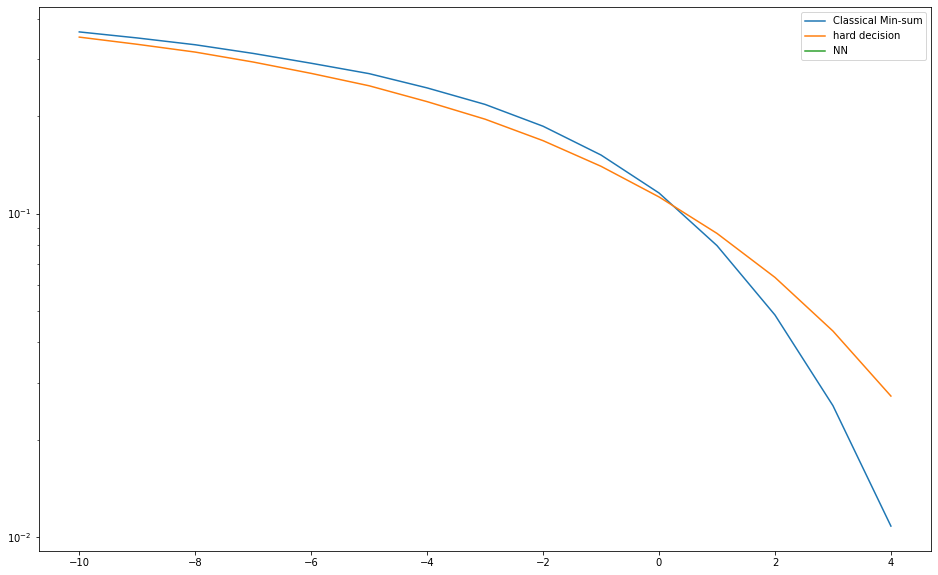

In [14]:
plt.figure(figsize=(16,10))
plt.semilogy(SNRs, bit_errors_min_sum.cpu() / nb_bits_min_sum.cpu(), label='Classical Min-sum')
plt.semilogy(SNRs, bit_errors_hard.cpu() / nb_bits_hard.cpu(), label='hard decision')
# for i in range(10):
plt.semilogy(SNRs, bit_errors_nn[77].cpu() / nb_bits_nn[77].cpu(), label=f'NN')
plt.legend()
plt.show()

In [15]:
decoder(soft_input)[0] - 0.5

tensor([ 0.3800,  0.2541,  0.1346,  0.2877,  0.3194,  0.3071,  0.3282,  0.1956,
         0.1905,  0.2885, -0.0609,  0.1512,  0.0674,  0.2957,  0.2206],
       device='cuda:0', grad_fn=<SubBackward0>)

In [16]:
codewords[0]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')

In [17]:
decoder.W_cv

Parameter containing:
tensor([[0.5830, 0.5247, 0.3474, 0.2779, 0.0779, 1.0077, 0.5689, 2.3038, 0.5753,
         1.0836, 0.2880, 0.3106, 0.5674, 2.2085, 2.0353, 0.2394, 1.2389, 0.4239,
         1.0792, 0.4784, 1.9006, 1.4196, 0.5626, 0.2366, 1.5963, 0.3488, 1.3359,
         1.3751, 0.7135, 0.3214, 0.5912, 0.8903],
        [0.7034, 0.5157, 0.2705, 1.6992, 0.1572, 0.8288, 0.5347, 1.1905, 0.3927,
         0.4966, 0.8318, 1.3949, 0.6431, 0.7269, 0.2019, 1.4643, 0.0632, 0.0844,
         1.9979, 0.5505, 0.1488, 0.2179, 1.4777, 0.2420, 0.2521, 1.3464, 1.8138,
         0.5404, 0.6906, 0.9023, 0.8250, 1.1046],
        [0.6171, 0.3797, 0.8749, 0.5181, 0.3217, 1.0620, 1.9209, 0.2616, 1.1972,
         0.5924, 0.3344, 0.4486, 0.3623, 0.1755, 2.5400, 0.5223, 1.0737, 0.6765,
         0.7578, 1.0843, 0.3591, 0.8660, 0.5200, 0.1159, 1.8499, 0.5865, 0.6620,
         0.0399, 0.6925, 1.9201, 0.7606, 1.5453],
        [0.6567, 0.0391, 0.6251, 1.1110, 0.3361, 0.5267, 0.0190, 0.8810, 0.6659,
         0.0541, 1

In [18]:
decoder.B_cv

Parameter containing:
tensor([[0.6306, 2.1131, 0.9339, 0.6698, 0.4331, 0.2294, 0.5381, 1.5161, 0.2964,
         0.3299, 0.6441, 0.2231, 0.2362, 1.3550, 0.2450, 0.3114, 1.2802, 1.7974,
         1.3755, 0.4993, 0.3191, 1.1621, 0.2767, 1.7009, 2.8481, 0.2752, 1.8519,
         2.9740, 0.8793, 0.3564, 1.6593, 0.2232],
        [0.1259, 1.1352, 0.5586, 1.4111, 0.2892, 0.7176, 1.4421, 2.1338, 1.0673,
         2.0640, 0.0864, 0.9451, 0.6602, 1.4973, 1.1811, 1.2205, 0.0963, 2.4258,
         0.2375, 1.2550, 0.9312, 0.6549, 1.1843, 0.6977, 0.0191, 0.8281, 0.6440,
         1.6842, 0.9658, 1.4133, 0.3054, 0.3617],
        [1.4866, 0.0387, 1.0001, 0.4812, 0.8063, 0.9006, 1.3319, 0.2439, 0.2794,
         1.0639, 0.2044, 0.8394, 0.9414, 1.6817, 0.8140, 1.1897, 0.6587, 0.4302,
         2.0665, 0.4267, 0.8961, 0.4352, 0.2945, 0.8164, 0.3223, 1.7000, 0.3851,
         1.4490, 0.1660, 0.2620, 0.7675, 1.1989],
        [0.6951, 1.3708, 0.1479, 1.2369, 0.0487, 1.9450, 0.4564, 1.1790, 0.9492,
         0.7366, 0